## Auslesen der Dateien ##

In [30]:
from ML_Preparation.Preprocessing_M import DataExtractor, DataPreprocessing

de = DataExtractor("D:/hka-aqm-m", "C:/Users/danie/building_M_data")

df = de.create_df()

No .dat files found in C:/Users/danie/building_M_data. 
 Trying to extract files from the original directory D:/hka-aqm-m
Read data successfully.
Data contains 979166 data points and 18 columns.


## Preprocessing ##

In [31]:
label = "CO2"

dp = DataPreprocessing(label = label)

df_preprocessed = dp.preprocess_df(df, rolling_window = "3d", sample_time = "1d")

Number of outliers detected: -73438
Number of normal samples detected: 905728


In [32]:
df_preprocessed.columns

Index(['date_time', 'tmp', 'hum', 'CO2', 'VOC', 'vis', 'IR', 'BLE', 'tavg',
       'tmin', 'tmax', 'wdir', 'wspd', 'wpgt', 'pres', 'room_number',
       'tmp_diff', 'hum_diff', 'VOC_diff', 'vis_diff', 'IR_diff', 'BLE_diff',
       'tavg_diff', 'tmin_diff', 'tmax_diff', 'wdir_diff', 'wspd_diff',
       'wpgt_diff', 'pres_diff', 'year', 'dayofweek', 'hour', 'season',
       'VOC_CO2_ratio'],
      dtype='object')

In [33]:
df_preprocessed_without_weather = df_preprocessed.drop(columns = ['tavg',
       'tmin', 'tmax', 'wdir', 'wspd', 'wpgt', 'pres',  'tavg_diff', 'tmin_diff', 'tmax_diff', 'wdir_diff', 'wspd_diff',
       'wpgt_diff', 'pres_diff'], axis = 1)

df_preprocessed_without_seasons = df_preprocessed.drop(columns = ["season"], axis = 1)

In [34]:
# df_preprocessed.to_parquet("hka_M_preprocessed.parquet")

## Feature Engineering ##

In [35]:
from ML_Preparation.Feature_Engineering import *

fe = FeatureEngineering(df_preprocessed,
                        label = label, 
                        categorical_features = ["season", "room_number", "dayofweek", "color"],
                        automated_feature_engineering = False)

X_train, y_train, X_test, y_test = fe.feature_engineering(steps_to_forecast = 2, skip_scale = True)

'color'


In [36]:
fe_no_weather = FeatureEngineering(df_preprocessed_without_weather,
                        label = label, 
                        categorical_features = ["season", "room_number", "dayofweek", "color"],
                        automated_feature_engineering = False)

X_train_nowe, y_train_nowe, X_test_nowe, y_test_nowe = fe_no_weather.feature_engineering(steps_to_forecast = 2, skip_scale = True)

fe_no_seasons = FeatureEngineering(df_preprocessed_without_seasons,
                        label = label, 
                        categorical_features = ["room_number", "dayofweek", "color"],
                        automated_feature_engineering = False)

X_train_nose, y_train_nose, X_test_nose, y_test_nose = fe_no_seasons.feature_engineering(steps_to_forecast = 2, skip_scale = True)

'color'
'color'


## Modelltraining ##

c:\Users\danie\anaconda3\envs\awp1\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



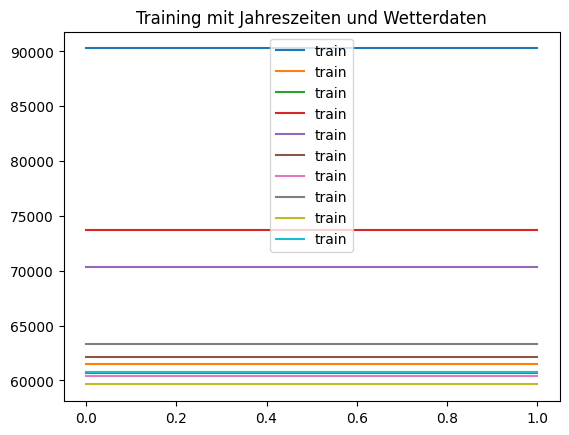

In [63]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Dropout, Bidirectional
from keras.optimizers import Adam, SGD
from matplotlib import pyplot

class MyLSTMModel:
    def __init__(self,
                 n_out,
                 feature_engineerer,
                 lstm_units=100,
                 ):
        self.feature_engineerer = feature_engineerer
        input_shape= (None, self.feature_engineerer.X_train.shape[-1])

        self.model = Sequential()
        self.model.add(LSTM(units=lstm_units, input_shape=input_shape, return_sequences = True, recurrent_dropout = 0.3))
        self.model.add(Dropout(0.3))
        self.model.add(Bidirectional(LSTM(units=lstm_units, recurrent_dropout = 0.3)))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(50, activation = "relu"))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(30, activation = "relu"))
        self.model.add(Dropout(0.3))

        self.model.add(Dense(n_out))

        self.model.compile(optimizer=Adam(learning_rate = 0.1), loss='mse')
    
    def summary(self):
        self.model.summary()

# Instantiate the model
model = MyLSTMModel(2, fe)

history = model.model.fit(fe.X_train, fe.y_train, epochs=10, batch_size=64, 
                             verbose = 0, 
                             shuffle=False
                             )

pyplot.plot(history.history['loss'], label='train')
pyplot.title("Training mit Jahreszeiten und Wetterdaten")
pyplot.legend()
pyplot.show()

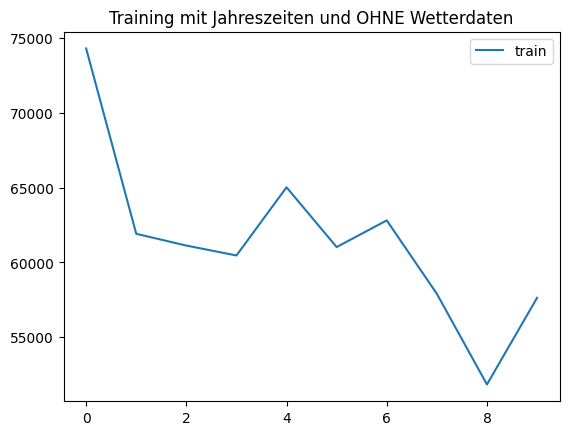

In [38]:
model_no_weather = MyLSTMModel(2, fe_no_weather)

history = model_no_weather.model.fit(fe_no_weather.X_train, fe_no_weather.y_train, epochs=10, batch_size=64, 
                             verbose = 0, 
                             shuffle=False
                             )

pyplot.plot(history.history['loss'], label='train')
pyplot.title("Training mit Jahreszeiten und OHNE Wetterdaten")
pyplot.legend()
pyplot.show()

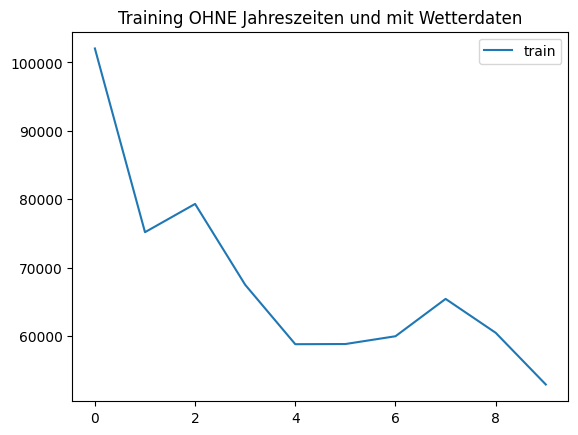

In [39]:
model_no_seasons = MyLSTMModel(2, fe_no_seasons)

history = model_no_seasons.model.fit(fe_no_seasons.X_train, fe_no_seasons.y_train, epochs=10, batch_size=64, 
                             verbose = 0, 
                             shuffle=False
                             )

pyplot.plot(history.history['loss'], label='train')
pyplot.title("Training OHNE Jahreszeiten und mit Wetterdaten")
pyplot.legend()
pyplot.show()

In [40]:
pred = model.model.predict(fe.X_test)
pred_no_weather = model_no_weather.model.predict(fe_no_weather.X_test)
pred_no_seasons = model_no_seasons.model.predict(fe_no_seasons.X_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


## Modellevaluation ##

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score
import plotly.express as px
import seaborn as sns


class Evaluator:

    def __init__(self):
        pass

    def evaluate(self, y_pred, y_true):
        print("MSE: ", self.calculate_mse(y_pred = y_pred, y_true = y_true))
        print("RMSE: ", self.calculate_rmse(y_pred = y_pred, y_true = y_true))
        print("MAPE: ", self.calculate_mape(y_pred = y_pred, y_true = y_true))
        print("R2: ", self.calculate_r2(y_pred = y_pred, y_true = y_true))
        print("\n")


    def calculate_mse(self, y_true, y_pred):
        return round(mean_squared_error(y_true = y_true, y_pred = y_pred), 2)

    def calculate_rmse(self, y_true, y_pred):
        return round(root_mean_squared_error(y_true = y_true, y_pred = y_pred), 2)

    def calculate_mape(self, y_true, y_pred):
        return round(mean_absolute_percentage_error(y_true = y_true, y_pred = y_pred), 2)

    def calculate_r2(self, y_true, y_pred):
        return round(r2_score(y_true = y_true, y_pred = y_pred), 2)

ev = Evaluator()

for col in range(0, fe.y_test.shape[1]):
    print(f"t +", col)
    print("Modell mit Wetterdaten und Jahreszeiten (rot)")
    ev.evaluate(y_true = fe.y_test[:, col], y_pred = pred[:, col])
    print("Modell ohne Wetterdaten und mit Jahreszeiten (grün)")
    ev.evaluate(y_true = fe_no_weather.y_test[:, col], y_pred = pred_no_weather[:, col])
    print("Modell mit Wetterdaten und ohne Jahreszeiten (violett)")
    ev.evaluate(y_true = fe_no_seasons.y_test[:, col], y_pred = pred_no_seasons[:, col])

    px.line(y = [fe.y_test[:, col], pred[:, col], pred_no_weather[:,col], pred_no_seasons[:, col]], 
             labels = {"wide_variable_0": "y_true",
                        "wide_variable_1": "Modell 1 - Vorhersage (Wetterdaten + Jahreszeiten)", 
                       "wide_variable_2": "Modell 2 - Vorhersage (Jahreszeiten)",
                       "wide_variable_3": "Modell 3 - Vorhersage (Wetterdaten)", },
             title = f"Prediction for CO2(t + {col})  blue = y_true, red = y_pred").show()


t + 0
Modell mit Wetterdaten und Jahreszeiten (rot)
MSE:  10993.24
RMSE:  104.85
MAPE:  0.15
R2:  -1.26


Modell ohne Wetterdaten und mit Jahreszeiten (grün)
MSE:  6414.55
RMSE:  80.09
MAPE:  0.13
R2:  -0.32


Modell mit Wetterdaten und ohne Jahreszeiten (violett)
MSE:  16139.17
RMSE:  127.04
MAPE:  0.21
R2:  -2.31




t + 1
Modell mit Wetterdaten und Jahreszeiten (rot)
MSE:  11223.01
RMSE:  105.94
MAPE:  0.16
R2:  -1.3


Modell ohne Wetterdaten und mit Jahreszeiten (grün)
MSE:  6617.57
RMSE:  81.35
MAPE:  0.13
R2:  -0.36


Modell mit Wetterdaten und ohne Jahreszeiten (violett)
MSE:  16614.6
RMSE:  128.9
MAPE:  0.21
R2:  -2.41




## Deployment bzw. Inferenz mit dem trainierten Modell ##

In [61]:
from Deployment.ML_Deployment import *

fe.df = df.copy()

deployer = Predictor(data = df, feature_engineering_class_object = fe, label = "CO2", is_forecast = True, roll = True, steps_to_forecast = 2)


'color'


In [62]:
deployer.predict(x = deployer.x, model = model.model)

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step


,prediction_t+0,prediction_t+1,room_number
date_time,,,
2022-06-01,263.723175,262.043945,m102
2022-06-02,256.782379,255.045120,m102
2022-06-03,383.846985,382.034058,m102
2022-06-04,429.427429,427.842926,m102
2022-06-20,389.619507,388.141846,m700
...,...,...,...
2023-09-26,390.164795,388.740509,m202
2023-09-26,376.164124,374.983124,m202
2023-09-26,440.852051,439.411957,m103
